In [10]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [17]:
aep = pd.read_csv('D:/parth/Projects/AEP_hourly.csv', index_col=[0], parse_dates=[0])

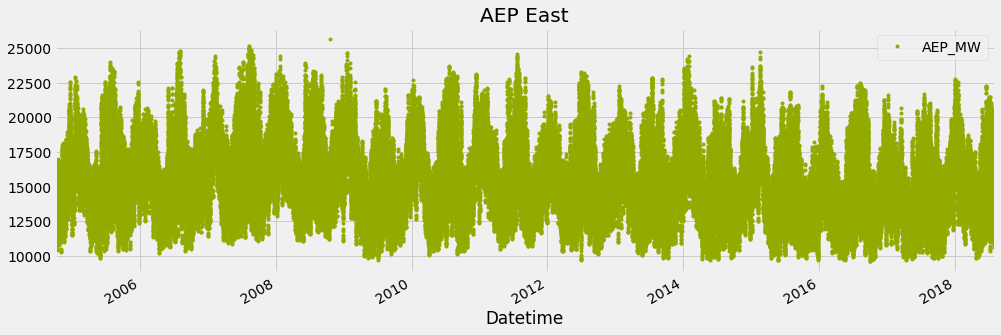

In [19]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = aep.plot(style='.', figsize=(15,5), color=color_pal[2], title='AEP East')

TEST/TRAIN SPLIT

In [20]:
split_date = '01-Jan-2015'
aep_train = aep.loc[pjme.index <= split_date].copy()
aep_test = aep.loc[pjme.index > split_date].copy()

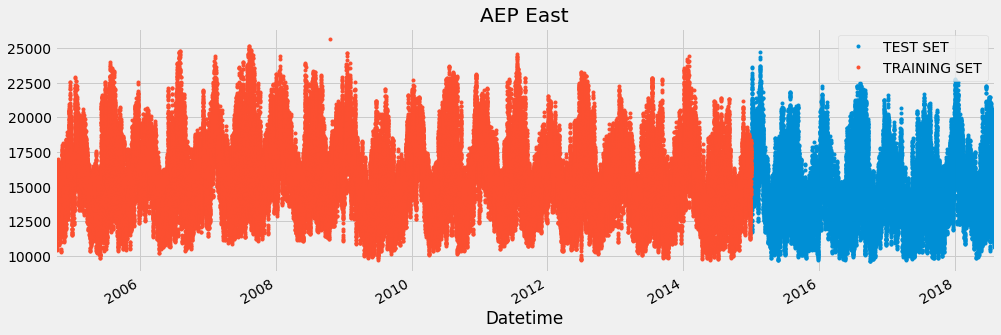

In [21]:
_ = aep_test \
    .rename(columns={'AEP_MW': 'TEST SET'}) \
    .join(aep_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='AEP East', style='.')

Creating Time Series Features

In [25]:
def new_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [26]:
X_train, y_train = new_features(aep_train, label='AEP_MW')
X_test, y_test = new_features(aep_test, label='AEP_MW')

Creating XGBOOST MODEL

In [27]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[0]	validation_0-rmse:11222.90723	validation_1-rmse:10311.86621
[1]	validation_0-rmse:7931.28174	validation_1-rmse:7034.17578
[2]	validation_0-rmse:5650.31934	validation_1-rmse:4850.94141
[3]	validation_0-rmse:4082.42310	validation_1-rmse:3455.44385
[4]	validation_0-rmse:3020.19165	validation_1-rmse:2532.72559
[5]	validation_0-rmse:2314.29150	validation_1-rmse:1984.89563
[6]	validation_0-rmse:1857.17578	validation_1-rmse:1728.25293
[7]	validation_0-rmse:1586.59973	validation_1-rmse:1614.13757
[8]	validation_0-rmse:1401.89075	validation_1-rmse:1616.38074
[9]	validation_0-rmse:1307.86487	validation_1-rmse:1613.73181
[10]	validation_0-rmse:1226.42956	validation_1-rmse:1631.92541
[11]	validation_0-rmse:1177.13648	validation_1-rmse:1645.60022
[12]	validation_0-rmse:1154.63928	validation_1-rmse:1657.50977
[13]	validation_0-rmse:1122.59473	validation_1-rmse:1667.47058
[14]	validation_0-rmse:1110.03894	validation_1-rmse:1670.05676
[15]	validation_0-rmse:1090.37122	validation_1-rmse:1678.60815


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Feature Importances
This is important as it gives us the general idea about which features is the model relying on  to make the prediction

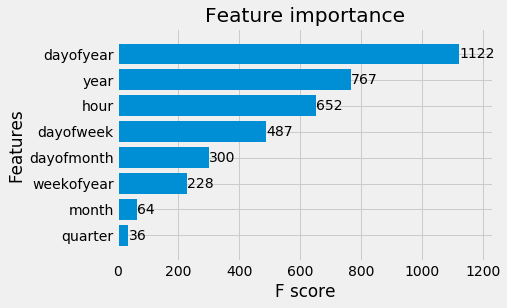

In [28]:
_ = plot_importance(reg, height=0.8)

Applying Forecast on Test Set

In [30]:
aep_test['MW_Prediction'] = reg.predict(X_test)
aep_all = pd.concat([aep_test, aep_train], sort=False)

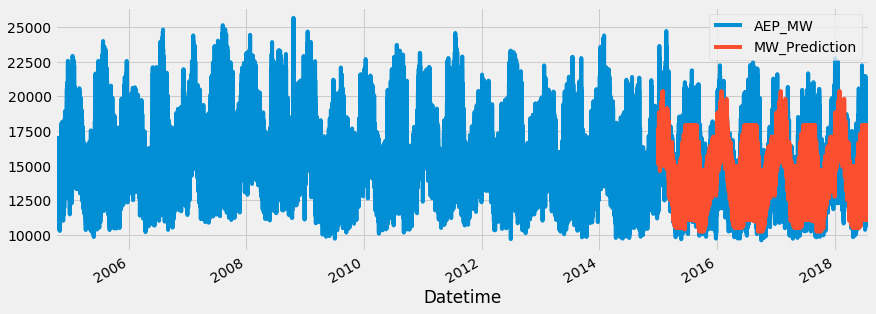

In [32]:
_ = aep_all[['AEP_MW','MW_Prediction']].plot(figsize=(13, 5))

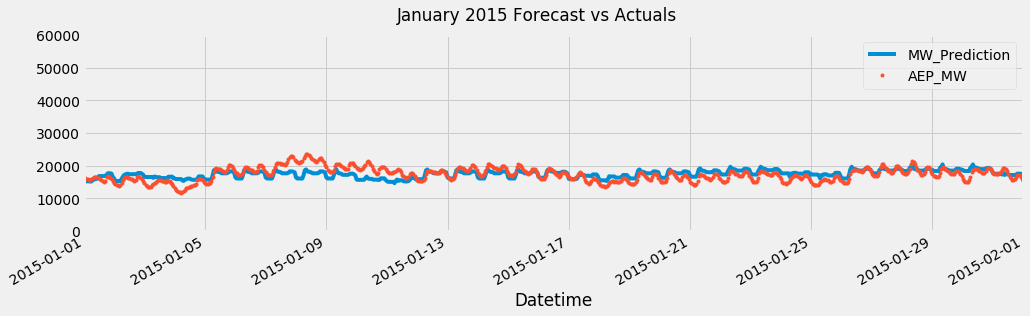

In [40]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)
_ = aep_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

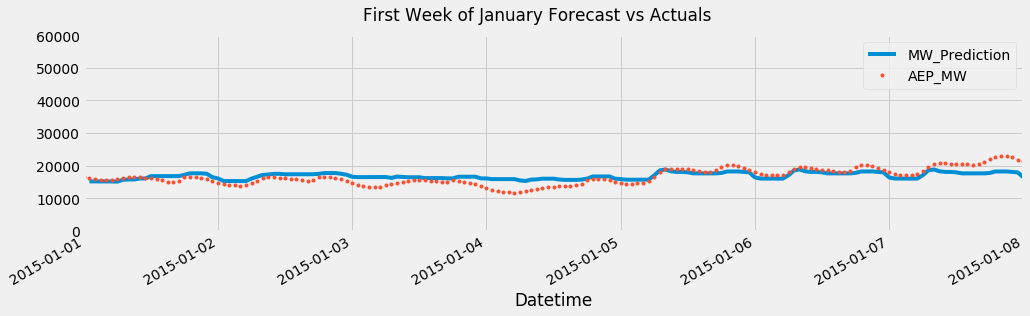

In [39]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)
_ = aep_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

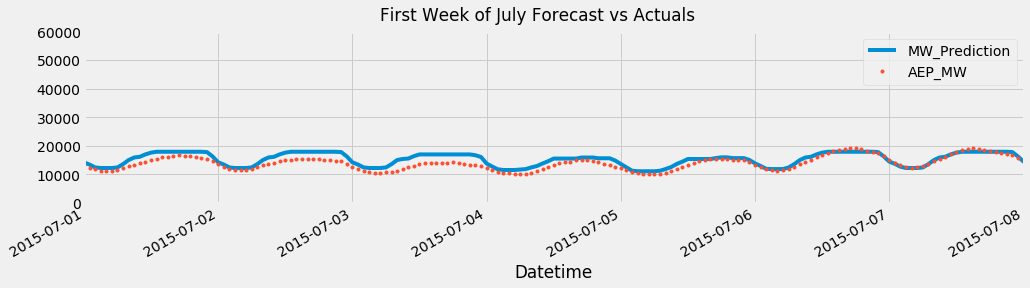

In [42]:
f, ax = plt.subplots(1)
f.set_figheight(3.5)
f.set_figwidth(15)
_ = aep_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

In [44]:
mean_squared_error(y_true=aep_test['AEP_MW'],
                   y_pred=aep_test['MW_Prediction'])

2604129.5553274993

In [45]:
mean_absolute_error(y_true=aep_test['AEP_MW'],
                   y_pred=aep_test['MW_Prediction'])

1237.3640072963715

In [46]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
mean_absolute_percentage_error(y_true=aep_test['AEP_MW'],
                   y_pred=aep_test['MW_Prediction'])

8.270429862369676